<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-weight:bold; font-size:16px;">
        This is 2nd of 2 EDA workbooks.  This one is for the Session-Level Modeling.
    </span>
</div>

<div style="background-color:#C7F9CC; padding:12px; border-radius:6px;">
    <span style="color:black; font-size:12px;">
OVERALL INSIGHTS FROM EDA

- Behavioral session features drive purchase behavior, core predictive power 
- Categorical features offer weak predictive separation 
- Data leakage is a critical concern for funnel-completion features. Confirmed leakage for 4 features ("chechout", "avg_discount_session", "total_quantitiy", "total_revenue_session") and must be excluded in modeling
- Outliers and skewness are expected and will be managed through transformation 
- The dataset is well-suited for tree-based models
  * naturally handle nonlinearity, skewed distributions, and multicollinearity.
</div>

In [1]:
# Load packages and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="Set2")

df = pd.read_csv('data/session_model_df.csv')

## Basic Structure & Data Quality Checks

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:12px;">
        
        - ACTIONS:
          * converted "start_time" and "signup_date" from object to datetime 
          * dropped "purchase" column, which was identical to "target_purchase"

</div>

#### code and output of df.shape, df.head(), df.info()

In [2]:
df.shape

(120000, 20)

In [3]:
df.head()

,session_id,customer_id,start_time,device,source,country,session_duration_min,n_events,n_distinct_products,total_quantity,total_revenue_session,avg_discount_session,add_to_cart,checkout,page_view,purchase,target_purchase,age,signup_date,marketing_opt_in
0,1,12360,2021-12-27 00:01:36,mobile,email,DE,118.0,10,7,3.0,0.00,0.0,3,0,7,0,0,43,2024-08-12,False
1,2,13917,2025-01-31 21:29:42,desktop,organic,PL,98.0,8,5,1.0,85.72,20.0,1,1,5,1,1,68,2025-07-09,True
2,3,1022,2024-02-19 00:52:50,tablet,organic,FR,25.0,5,2,1.0,116.17,0.0,1,1,2,1,1,45,2023-03-31,False
3,4,2882,2024-08-04 19:54:31,mobile,direct,GB,53.0,2,2,0.0,0.00,0.0,0,0,2,0,0,23,2022-05-20,False
4,5,1286,2022-06-28 13:58:08,desktop,email,ES,89.0,6,6,0.0,0.00,0.0,0,0,6,0,0,22,2021-06-15,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   session_id             120000 non-null  int64  
 1   customer_id            120000 non-null  int64  
 2   start_time             120000 non-null  object 
 3   device                 120000 non-null  object 
 4   source                 120000 non-null  object 
 5   country                120000 non-null  object 
 6   session_duration_min   120000 non-null  float64
 7   n_events               120000 non-null  int64  
 8   n_distinct_products    120000 non-null  int64  
 9   total_quantity         120000 non-null  float64
 10  total_revenue_session  120000 non-null  float64
 11  avg_discount_session   120000 non-null  float64
 12  add_to_cart            120000 non-null  int64  
 13  checkout               120000 non-null  int64  
 14  page_view              120000 non-nu

In [5]:
# Convert start_time and signup_date from object to datetime
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')

# check results
df[['start_time', 'signup_date']].dtypes

start_time     datetime64[ns]
signup_date    datetime64[ns]
dtype: object

In [6]:
df.duplicated().sum()

0

#### Insights on Numeric Features

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:12px;">
        
Several numeric features (ie. "total_revenue_session", "avg_discount_session") are heavily right-skewed > log transform

A large proportion of sessions show zero purchase-related actions (aligned with normal browsing behavior). 

"purchase" and "target_purchase" are duplicates with identical statistics > dropped "purchase" colums

Session duration has a long-tailed distribution > scale 

Behavioral variables such as page_view, n_events, and n_distinct_products show good variability

Age distribution (18–75) appears realistic > consider age-banding may improve interpretability.

The purchase rate is ~28%, indicating moderate class imbalance but not enough to warrant aggressive resampling.


</div>

In [7]:
# get statistics of numeric columns

# Columns to exclude
exclude_cols = ['customer_id', 'session_id']

# Select numeric columns except excluded ones
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Generate descriptive statistics
numeric_summary = df[numeric_cols].describe().T

numeric_summary

,count,mean,std,min,25%,50%,75%,max
session_duration_min,120000.0,75.147924,42.113897,1.0,40.0,73.0,107.0,223.00
n_events,120000.0,6.341317,3.424481,1.0,3.0,6.0,9.0,17.00
n_distinct_products,120000.0,4.468017,2.277196,1.0,2.0,4.0,6.0,8.00
total_quantity,120000.0,1.552617,1.699198,0.0,0.0,1.0,2.0,15.00
total_revenue_session,120000.0,37.443479,100.421301,0.0,0.0,0.0,19.5,2984.58
avg_discount_session,120000.0,2.003667,5.095802,0.0,0.0,0.0,0.0,20.00
add_to_cart,120000.0,1.192717,1.126382,0.0,0.0,1.0,2.0,8.00
checkout,120000.0,0.374242,0.483929,0.0,0.0,0.0,1.0,1.00
page_view,120000.0,4.494525,2.294119,1.0,2.0,4.0,7.0,8.00
purchase,120000.0,0.279833,0.448919,0.0,0.0,0.0,1.0,1.00


In [8]:
# Drop the "purchase" column - which is a duplicate of target_purchase column
df = df.drop(columns=['purchase'])

#### Insights on Categorical Features

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:12px;">
        
Categorical features show clear and meaningful patterns that are likely useful for predicting conversion.

Device, traffic source, & marketing opt-in display strong segmentation = aligns with user behavior differences.

Country exhibits long-tail distribution; consider simplifying rare categories.

These categorical features should be one-hot encoded or target-encoded depending on model type.

</div>

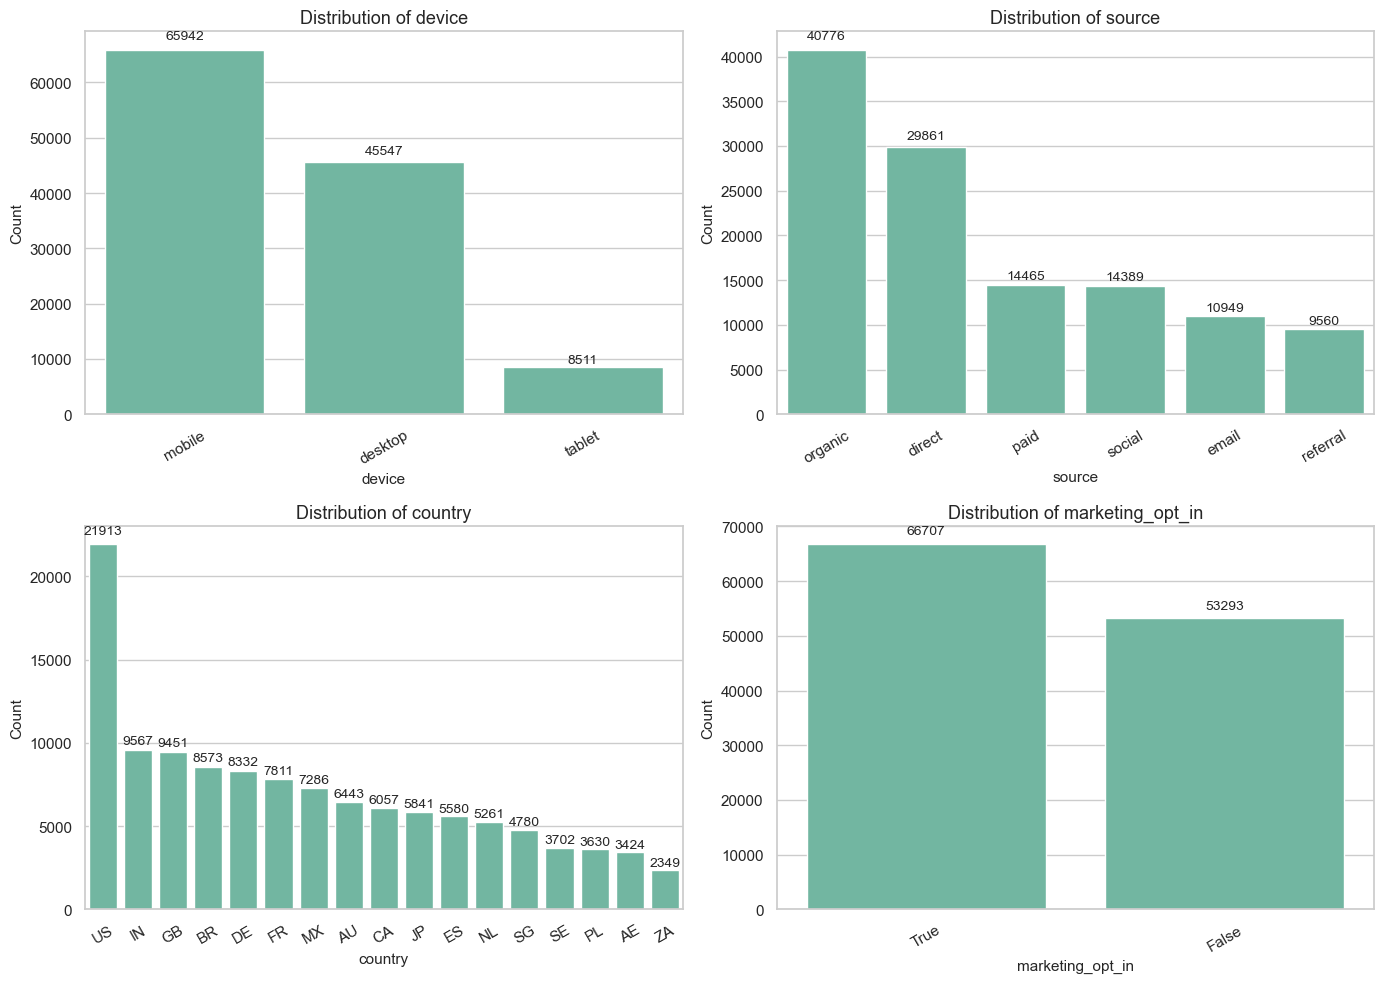

In [9]:
# inspect non numeric columns

categorical_cols = ["device", "source", "country", "marketing_opt_in"]

# Set up a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(categorical_cols):
    ax = axes[i]

    # Order categories by frequency
    order = df[col].value_counts().index
    
    # Bar plot
    sns.countplot(x=col, data=df, order=order, ax=ax)

    # Add value labels above bars
    counts = df[col].value_counts()
    for j, value in enumerate(counts):
        ax.text(j, value + 0.02 * value,
                str(value),
                ha='center', va='bottom',
                fontsize=10, fontweight='normal')  # ensure NOT bold

    ax.set_title(f"Distribution of {col}", fontsize=13)
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(axis='x', rotation=30)

# Adjust layout
plt.tight_layout()
plt.show()


## Target Variable Analysis

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:14px;">
        
The target variable target_purchase shows a 72% non-purchase vs. 28% purchase distribution.  This represents a moderate class imbalance — the majority class is ~2.6× larger than the minority class.  While not severe, this imbalance means accuracy alone is not a reliable metric, and evaluation should include precision, recall, F1-score, and ROC-AUC.
</div>

In [10]:
df['target_purchase'].value_counts(normalize=True)

target_purchase
0    0.720167
1    0.279833
Name: proportion, dtype: float64

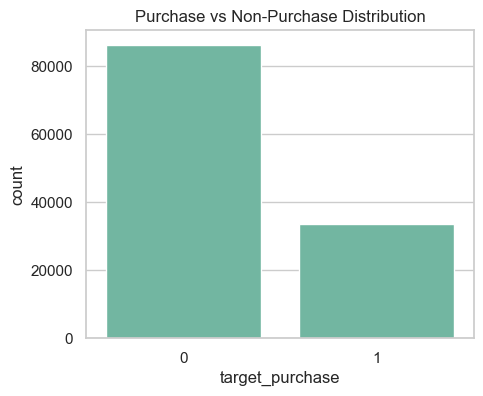

In [11]:
plt.figure(figsize=(5,4))
sns.countplot(x='target_purchase', data=df)
plt.title("Purchase vs Non-Purchase Distribution")
plt.show()

## Univariate Analysis of Features

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:14px;">
        
Histograms and boxplots support findings from statistical analysis.  
  * Most behavioral features exhibit clear, meaningful structure and good variability.
  * Purchase-related features have large zero masses and strong right tails, consistent with funnel behavior.
  * No obvious data quality issues (e.g., impossible values).
  * Multiple variables may benefit from log-scaling, binning, or treating zero vs. non-zero as a separate feature.
  * Several numeric variables show strong right-skew and outliers because most sessions involve low engagement or no purchase activity.
  * These outliers are meaningful behavioral patterns, not noise.
  * Transformations (log, clipping, binning) may improve modeling depending on algorithm choice.
  * Engagement-related variables (events, page views, products viewed, add-to-cart) show good spread and are likely strong predictors.

</div>

/var/folders/fs/qg27m43n3sj3bg7816ln66g40000gn/T/ipykernel_6292/4199387613.py:13: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[numeric_cols].hist(bins=30, ax=axes)


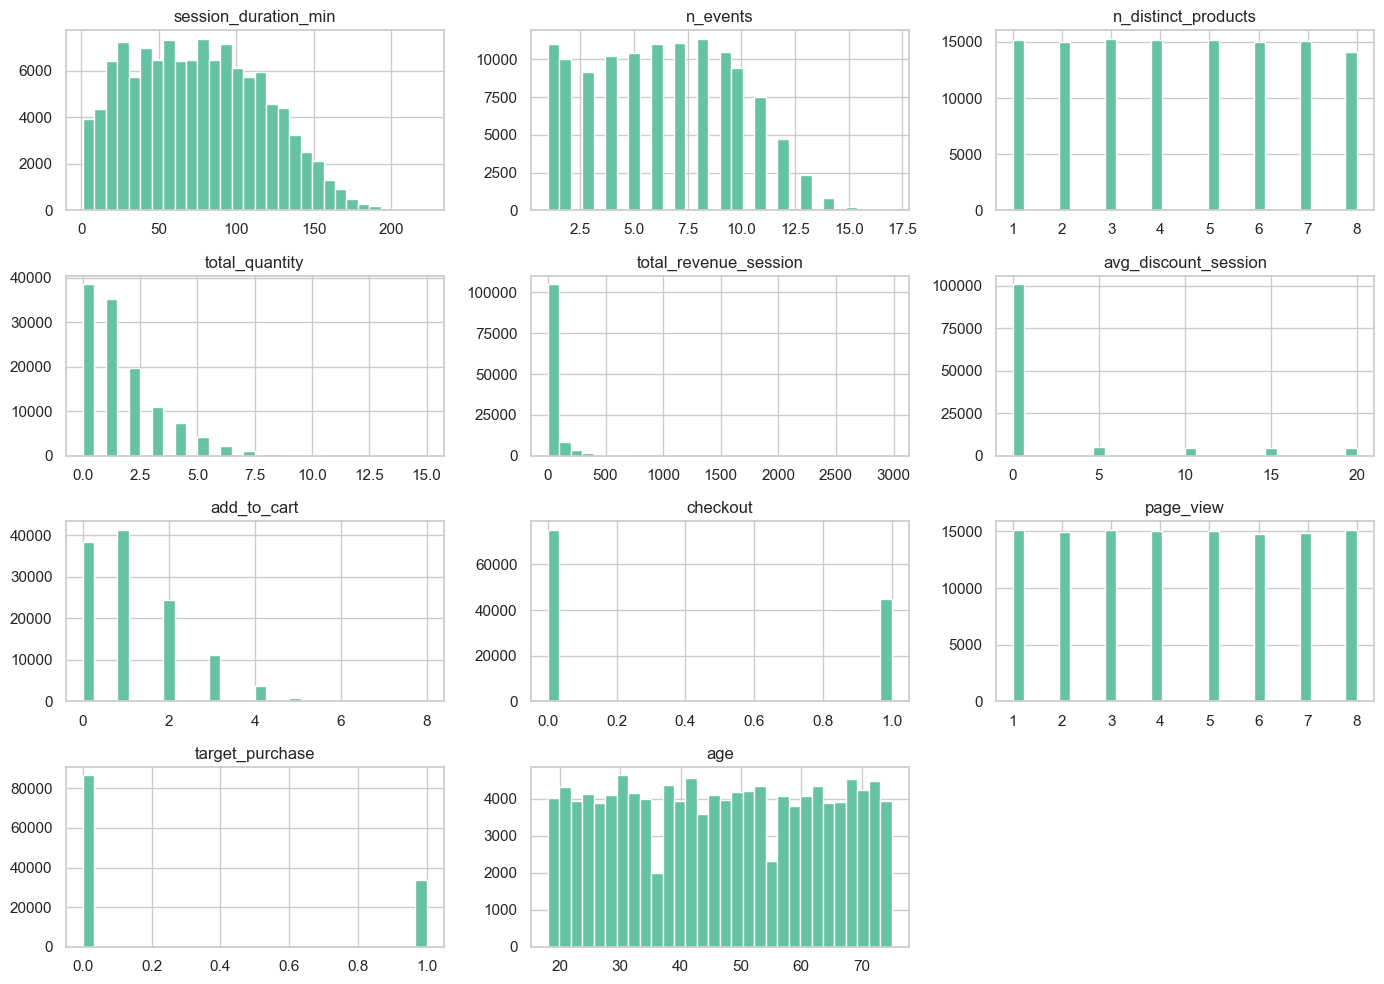

In [12]:
# create histograms for numerical columns

# Numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Exclude ID columns
exclude_cols = ['customer_id', 'session_id']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Create the histogram figure explicitly
fig, axes = plt.subplots(figsize=(14,10))

df[numeric_cols].hist(bins=30, ax=axes)
plt.tight_layout()

plt.show()


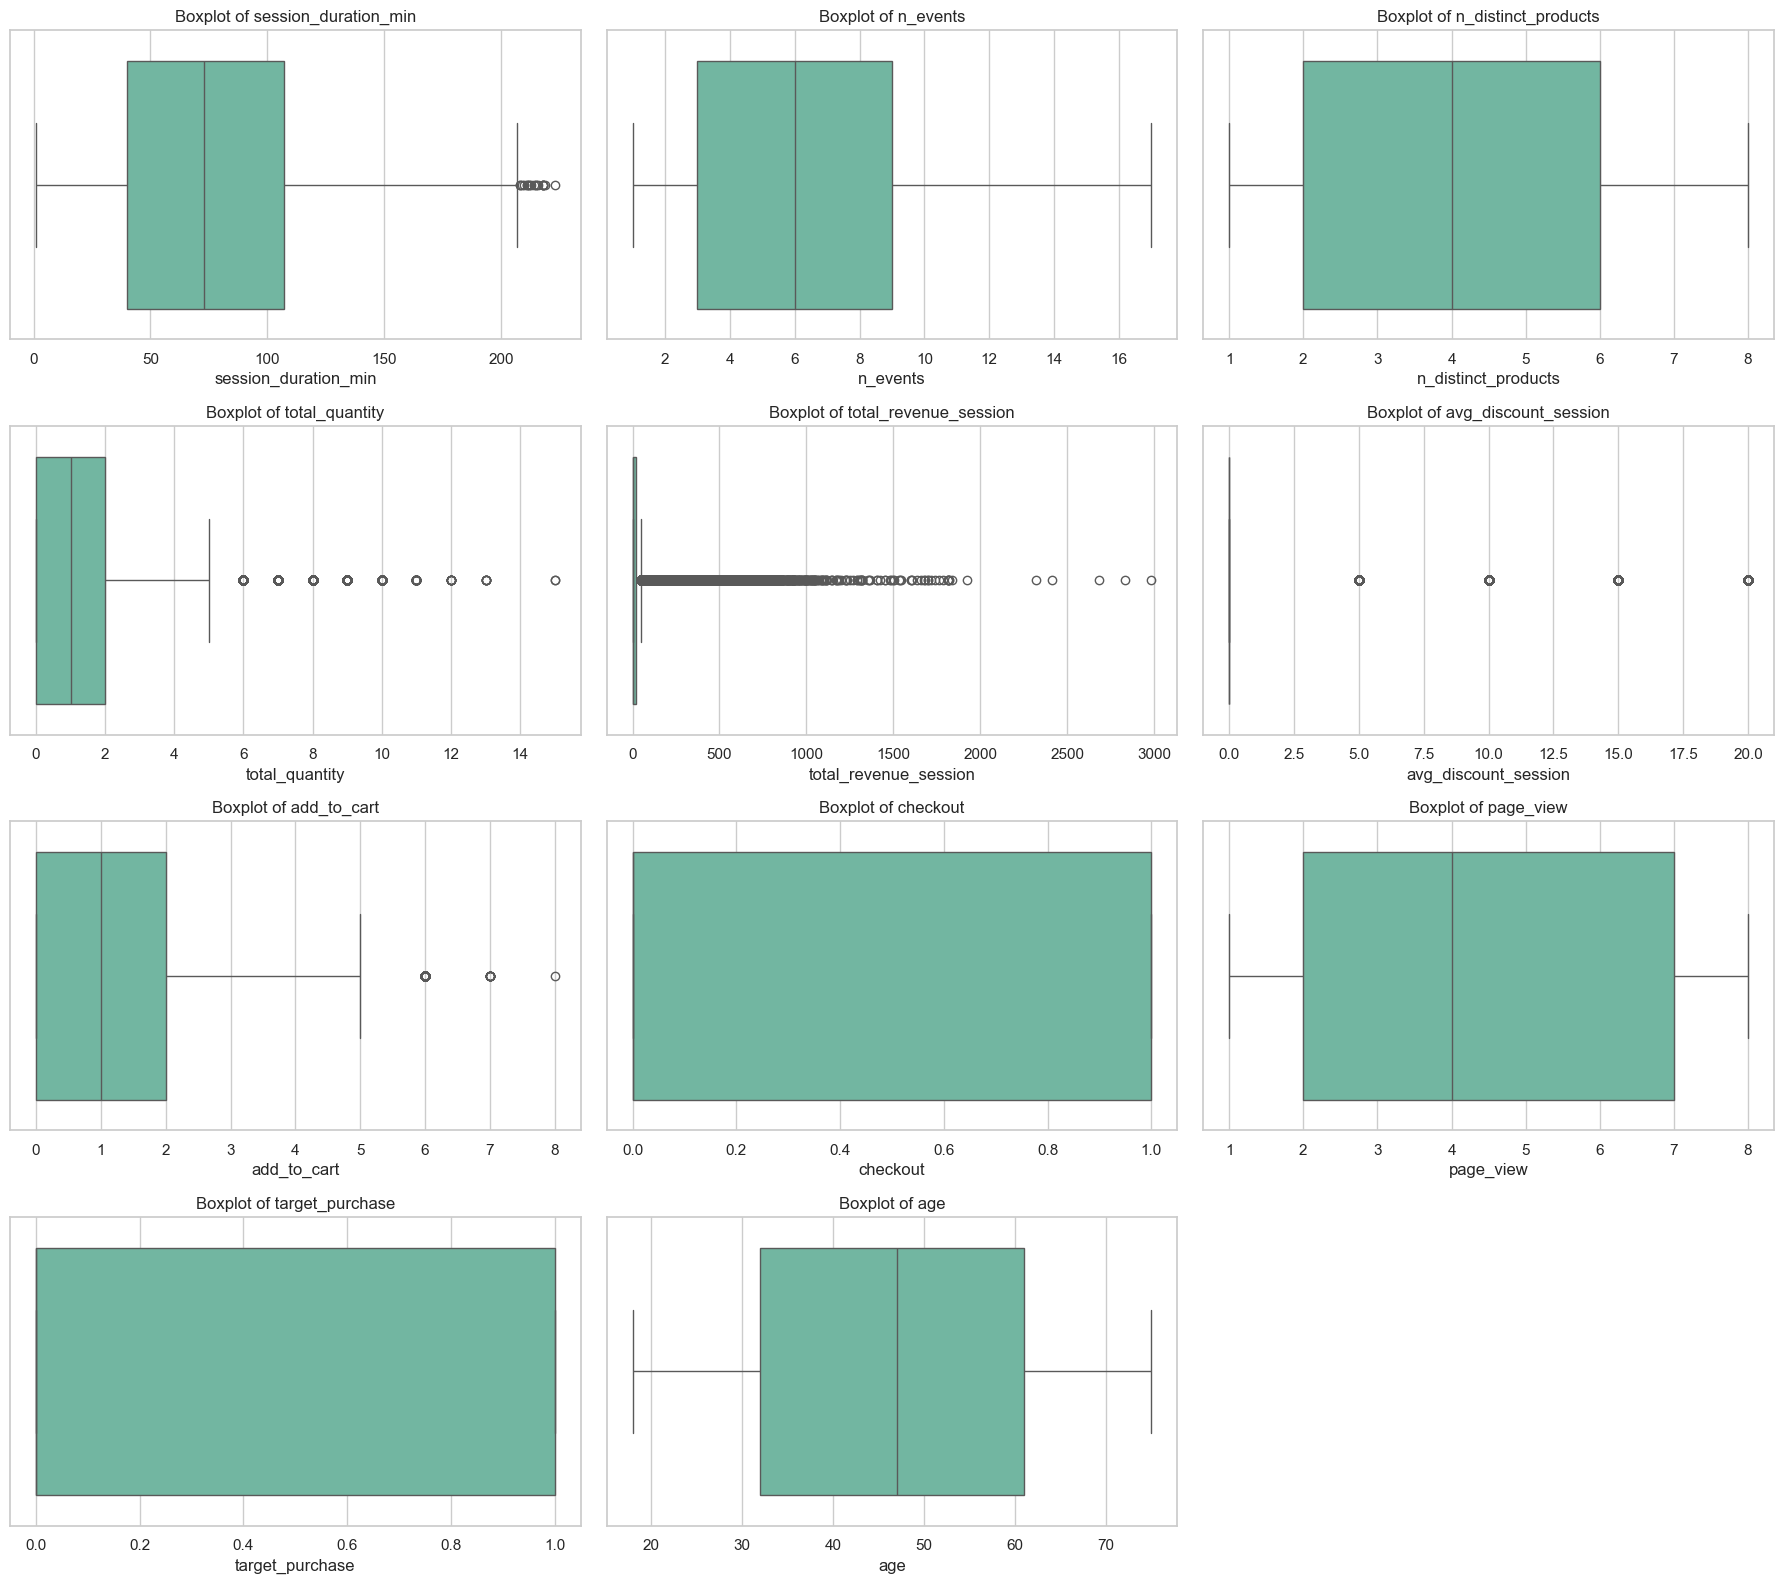

In [13]:
import math

# Exclude ID columns if needed
exclude_cols = ['customer_id', 'session_id']
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in exclude_cols]

# Layout: 3 columns, dynamic number of rows
n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Make axes indexable

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}", fontsize=12)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

plt.show()


## Bivariate Analysis - Impact of Features on Purchase


#### Numeric Features

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:14px;">    
 
  - Engagement features (events, pages, products viewed) strongly separate purchasers from non-purchasers.
  - Funnel features (add_to_cart, checkout) show the clearest separation — these will likely have the greatest predictive power.
  - Revenue and discount variables behave exactly as expected but may pose leakage risks depending on data timing.
  - Session duration has only mild separation; age has none, so these may act as weak predictors.

</div>

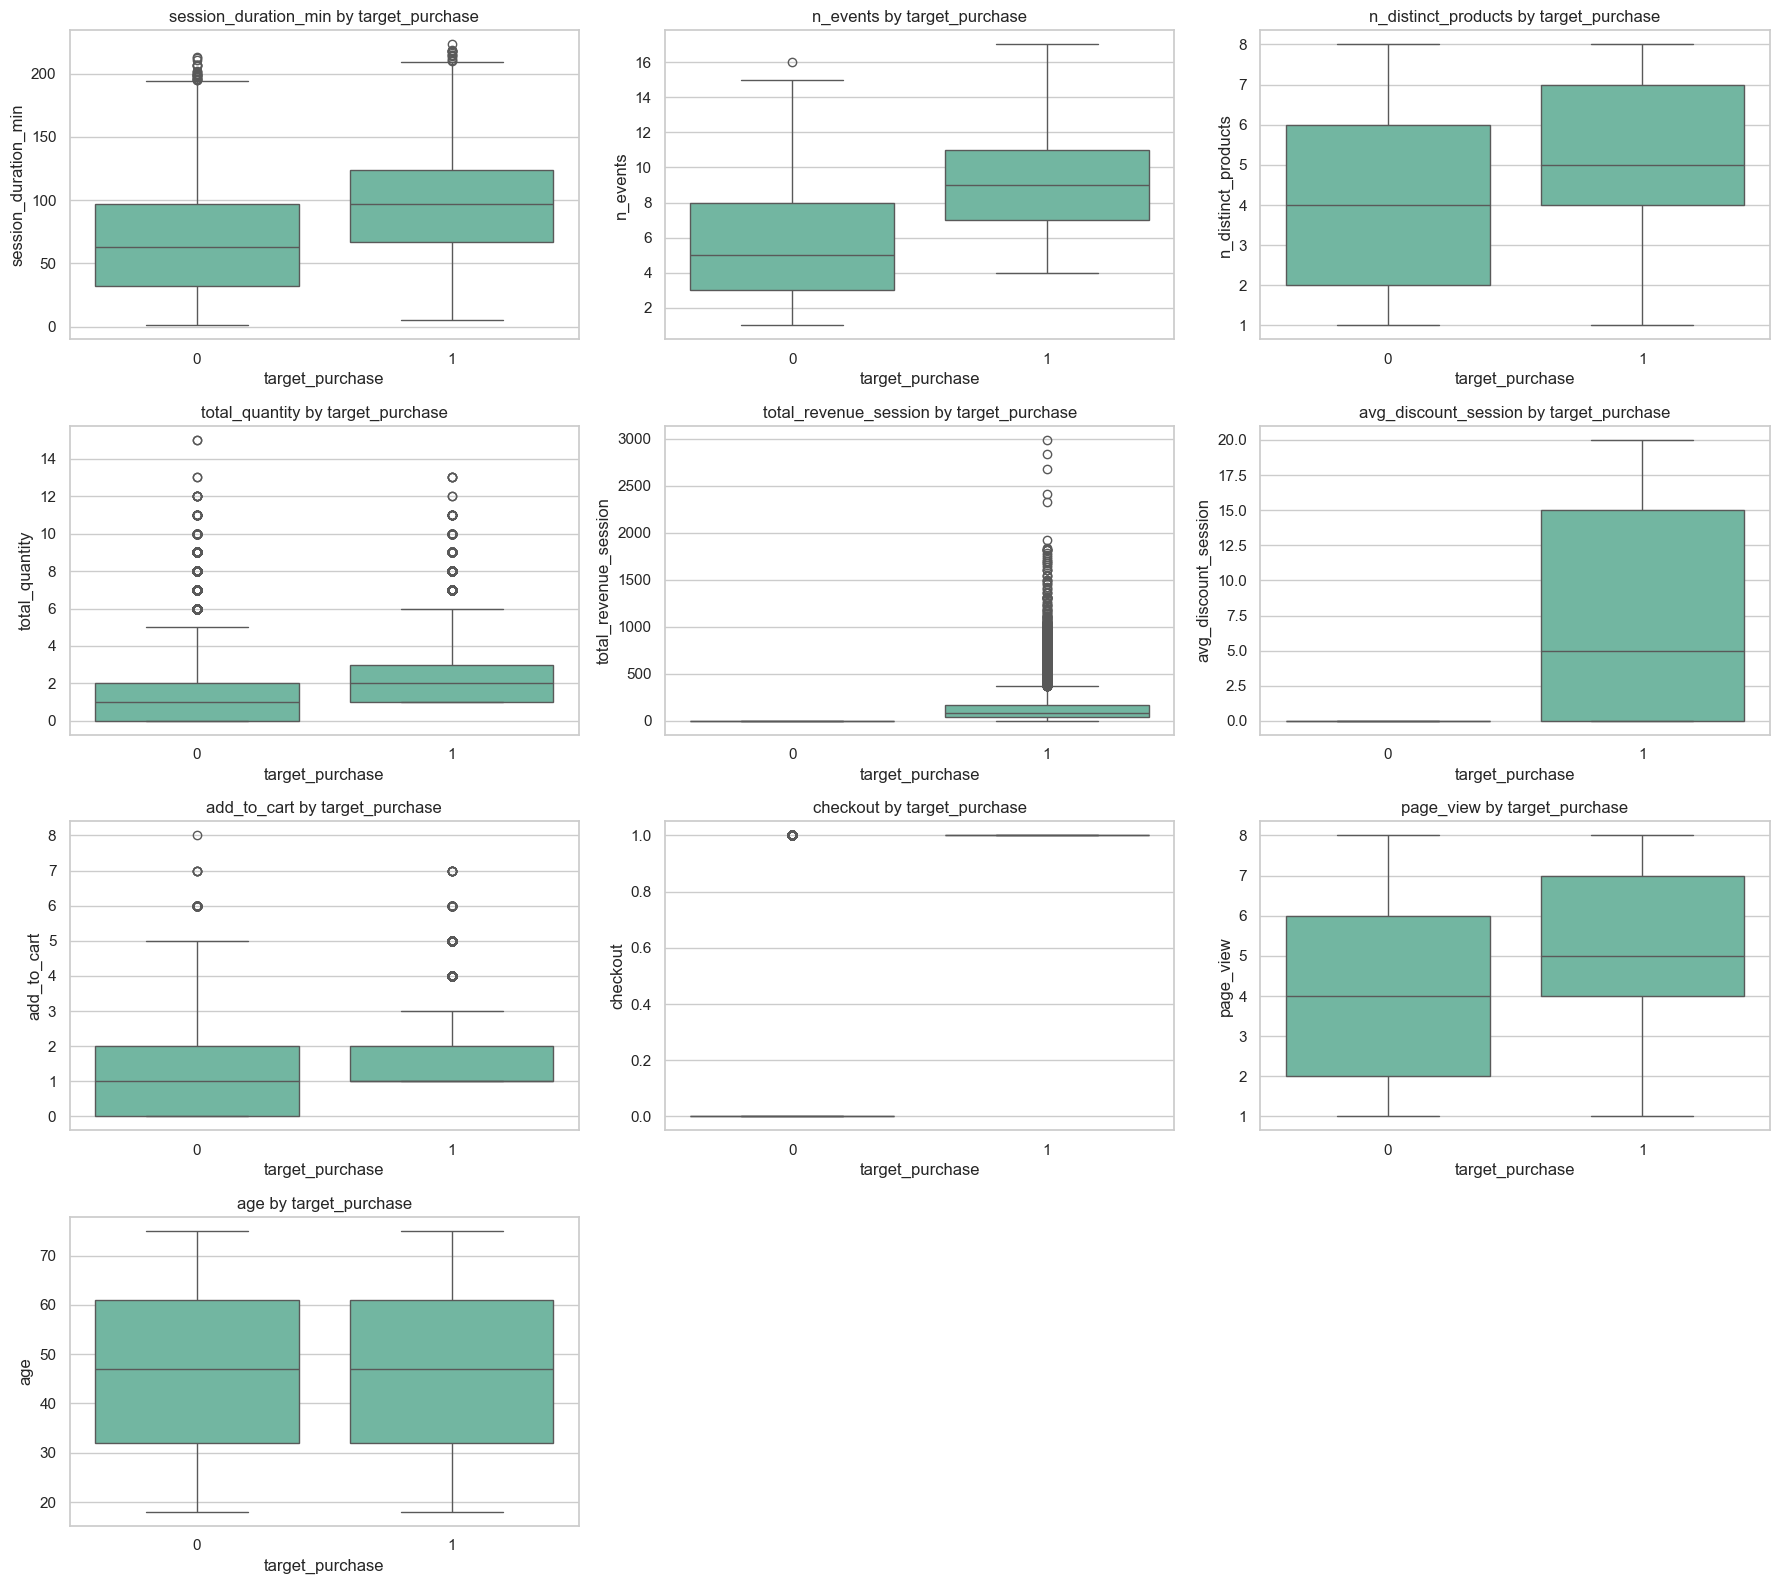

In [14]:
# Numeric columns for bivariate analysis (exclude IDs + target)
exclude_cols = ['customer_id', 'session_id', 'target_purchase']
numeric_cols_bi = [
    col for col in df.select_dtypes(include='number').columns
    if col not in exclude_cols
]

n_cols = 3
n_rows = math.ceil(len(numeric_cols_bi) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_bi):
    sns.boxplot(x='target_purchase', y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} by target_purchase", fontsize=12)
    axes[i].set_xlabel("target_purchase")
    axes[i].set_ylabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### Categorical Features

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:14px;">    
 
   -  Purchase rate bar charts show that categorical variables—including device, traffic source, country, and marketing opt-in—exhibit only very small differences in conversion rate (generally within a 1–2 percentage point range).
   -  None of these features individually show strong predictive separation between purchase and non-purchase sessions.
   -  While they may contribute marginally to the model when combined with other features or encoded appropriately, the primary predictive signal in this dataset comes from numeric behavioral features (page views, events, products viewed, add-to-cart, checkout, etc.).
   -  Based on this analysis, categorical features are kept for completeness, but expectations for their standalone predictive power should be low.

</div>

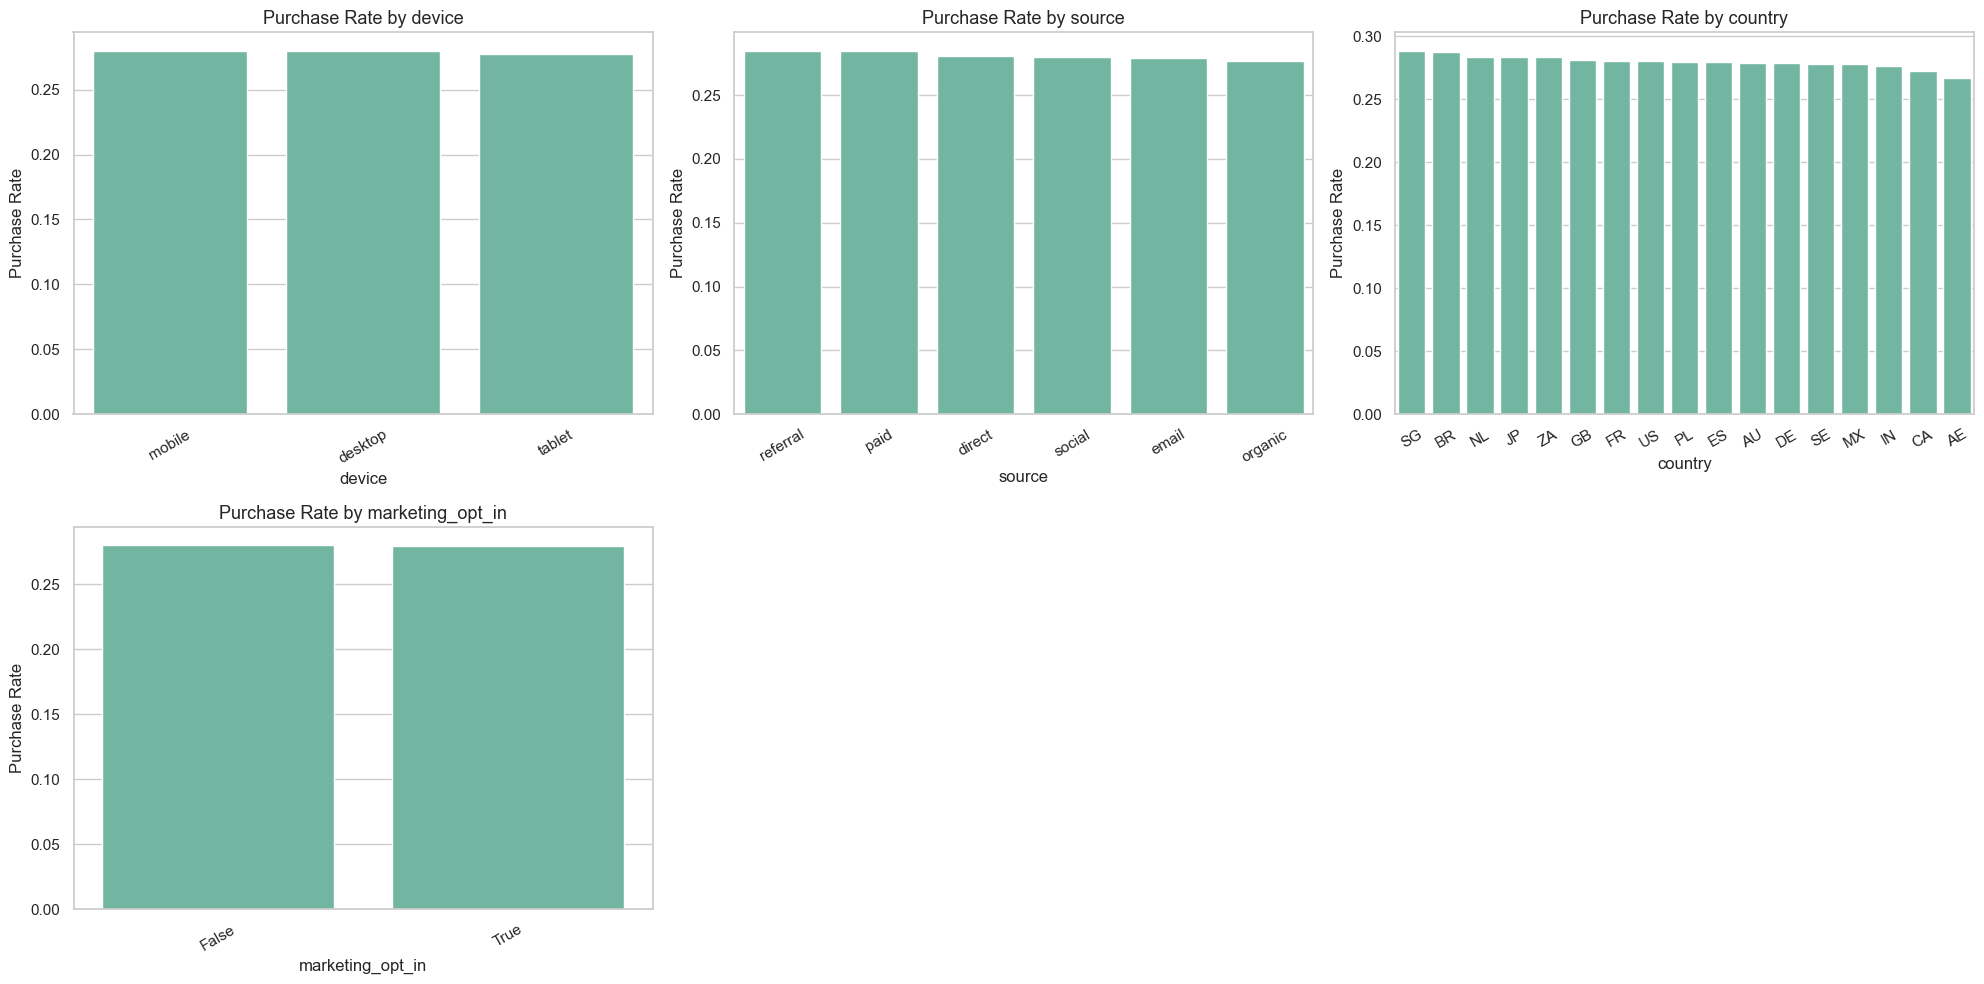

In [15]:
# Identify categorical columns (object, category, bool)
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# (Optional) Remove columns that should not be treated as categorical
exclude_cols = []  # e.g., ['some_id_col'] if needed
cat_cols = [c for c in cat_cols if c not in exclude_cols]

# Layout: 3 columns, dynamic number of rows
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):

    # Compute purchase rate per category
    rate = df.groupby(col)['target_purchase'].mean().sort_values(ascending=False)

    # Barplot
    sns.barplot(x=rate.index, y=rate.values, ax=axes[i])

    axes[i].set_title(f"Purchase Rate by {col}", fontsize=13)
    axes[i].set_ylabel("Purchase Rate")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=30)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Correlation Analysis

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:14px;">
        
-  The dataset shows two clear feature clusters: (1) Engagement Behavior and (2) Funnel Progression.
-  Multicollinearity exists within these clusters, but it is expected and manageable.
-  Funnel features and engagement metrics will likely be top predictors of purchase.
-  Age is largely independent and adds minimal modeling value.
-  Revenue and discount features correlate strongly with funnel variables — reinforcing the need to verify no data leakage.

</div>

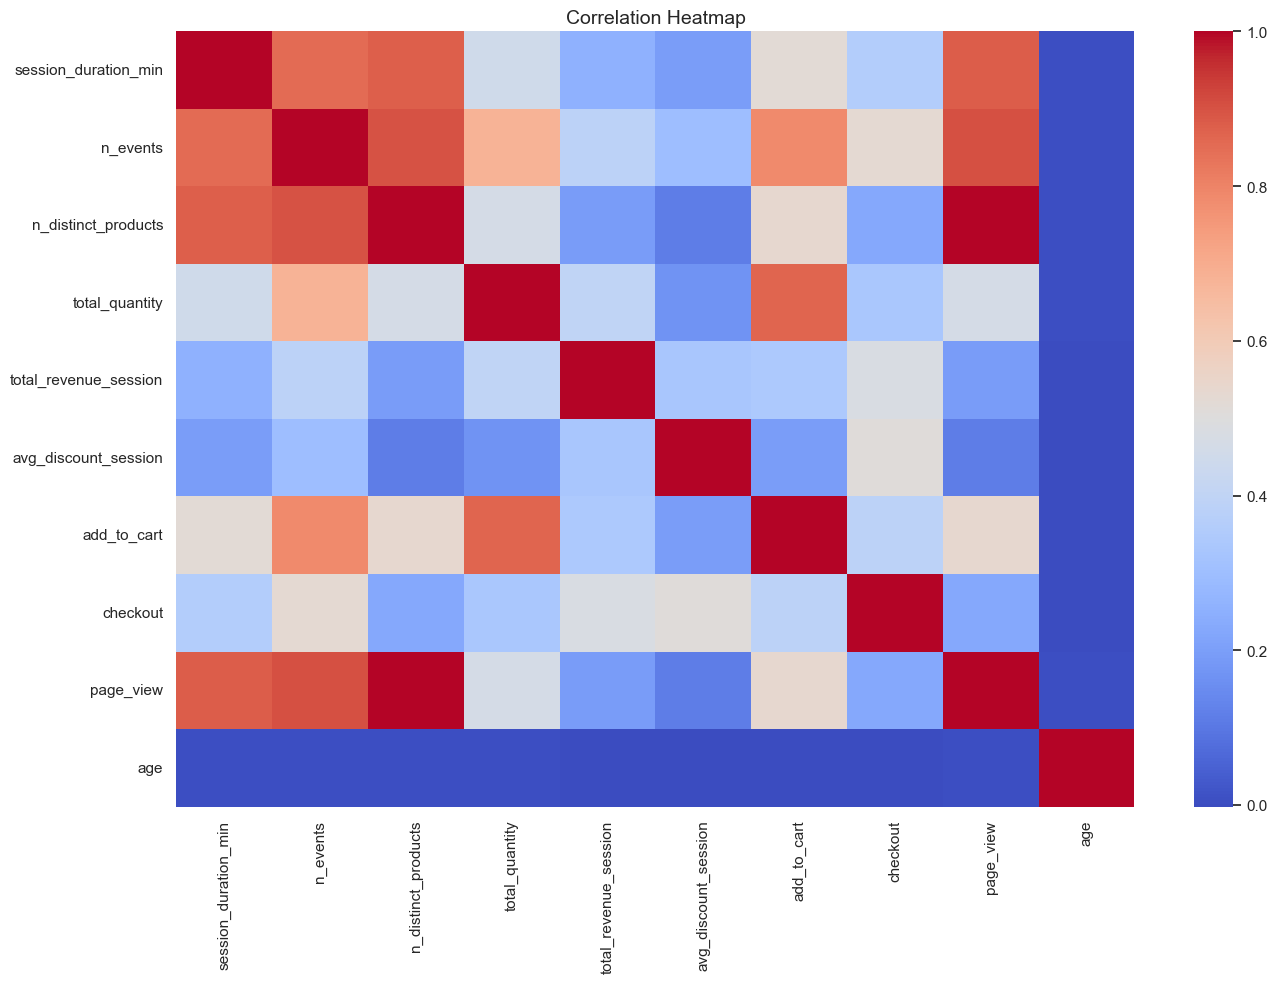

In [17]:
# Select numeric columns and exclude ID/target columns if needed
exclude_cols = ['customer_id', 'session_id', 'target_purchase']
numeric_cols = [c for c in df.select_dtypes(include='number').columns
                if c not in exclude_cols]

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(corr, cmap='coolwarm', annot=False)

plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()

plt.show()


## Interaction / Behavioral

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:12px;">

-  All engagement metrics (events, pages, distinct products) are higher for purchasers.  
-  These are excellent non-leaking predictors of purchase intent.
-  Funnel metrics (add_to_cart, checkout, total_quantity) show the largest gaps — and may contain leakage depending on the dataset's construction.
-  Checkout is likely post-purchase.
-  Revenue, quantity, and discount (not shown here) must also be checked for leakage.
-  Session duration differences are modest but directionally consistent.
-  Behavior-driven features are clearly the strongest drivers of purchase prediction.
-  Categorical features, in contrast, contributed almost no separation.

</div>

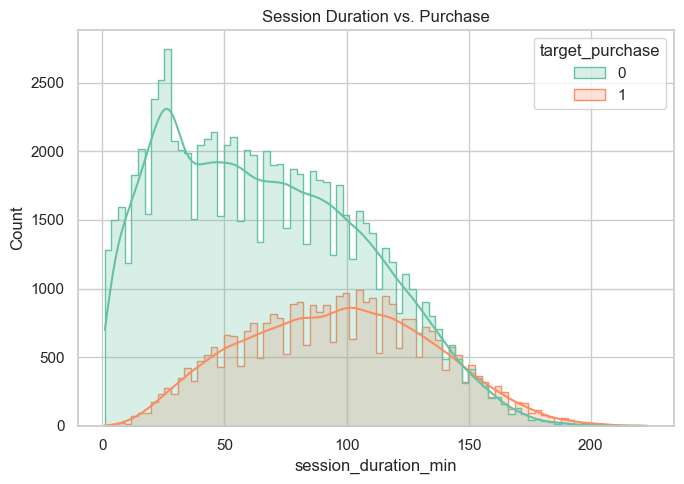

In [18]:
# session duration vs. purchase

plt.figure(figsize=(7,5))
sns.histplot(data=df, x="session_duration_min", hue="target_purchase", kde=True, element="step")
plt.title("Session Duration vs. Purchase")
plt.tight_layout()
plt.show()

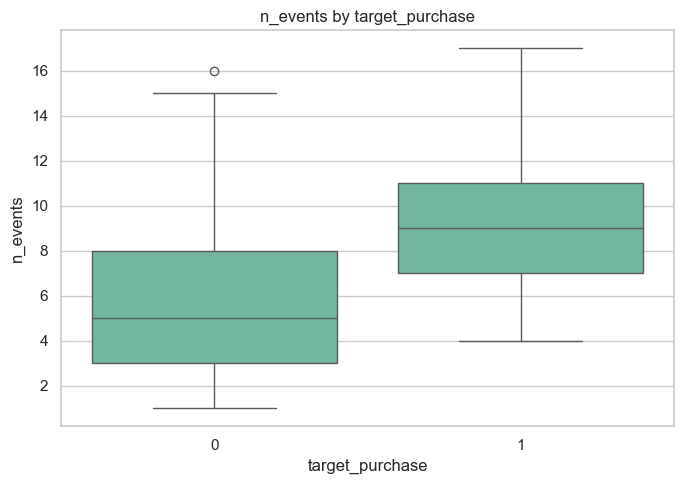

In [19]:
# no. of events vs. purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='n_events', data=df)
plt.title("n_events by target_purchase")
plt.tight_layout()

# Save PNG
plt.savefig("interaction_n_events_vs_purchase.png", dpi=300)

plt.show()

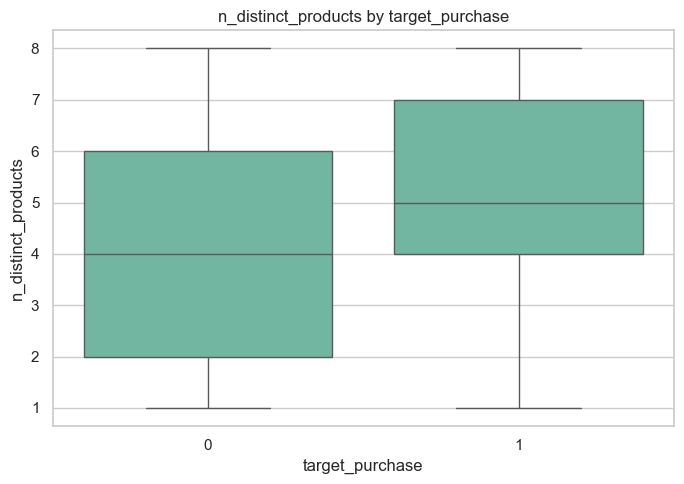

In [19]:
# distict products vs purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='n_distinct_products', data=df)
plt.title("n_distinct_products by target_purchase")
plt.tight_layout()
plt.show()

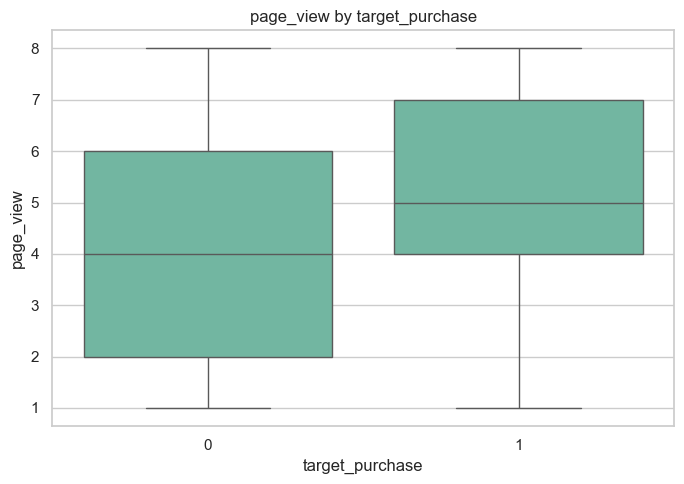

In [20]:
# page views vs purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='page_view', data=df)
plt.title("page_view by target_purchase")
plt.tight_layout()
plt.show()

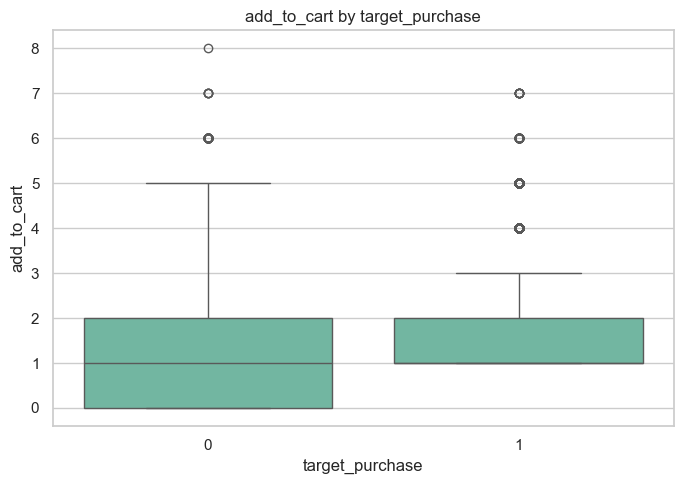

In [21]:
# add to cart vs purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='add_to_cart', data=df)
plt.title("add_to_cart by target_purchase")
plt.tight_layout()
plt.show()

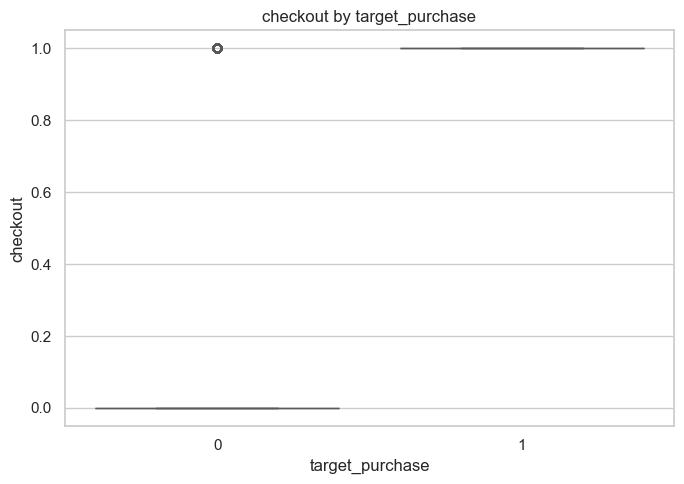

In [23]:
# checkout vs purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='checkout', data=df)
plt.title("checkout by target_purchase")
plt.tight_layout()

# Save PNG
plt.savefig("interaction_checkout_vs_purchase.png", dpi=300)

plt.show()

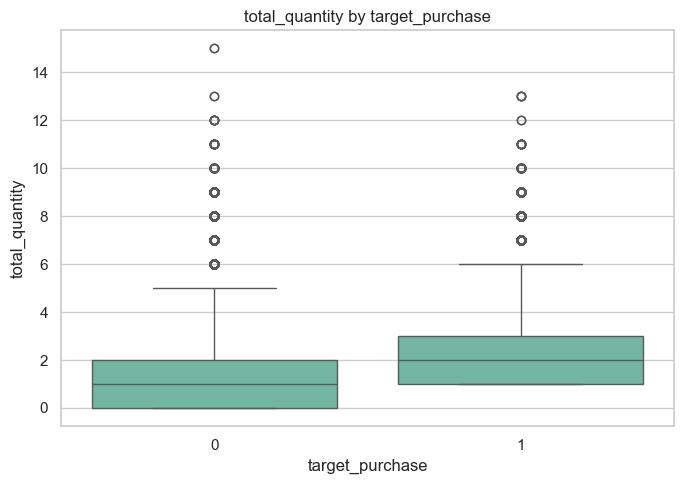

In [22]:
# total quantity vs purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='total_quantity', data=df)
plt.title("total_quantity by target_purchase")
plt.tight_layout()
plt.show()

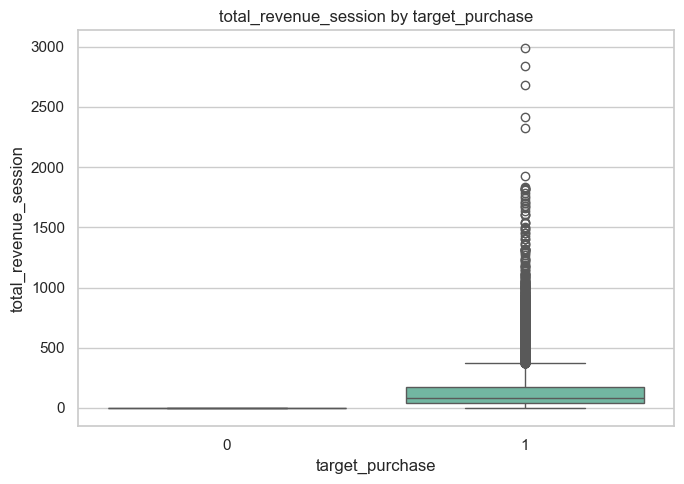

In [23]:
# total revenue vs. purcahse

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='total_revenue_session', data=df)
plt.title("total_revenue_session by target_purchase")
plt.tight_layout()
plt.show()

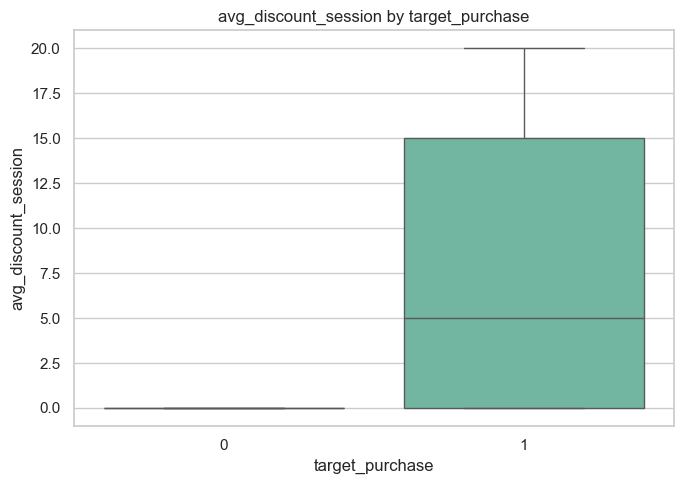

In [24]:
# average discount vs. purchase

plt.figure(figsize=(7,5))
sns.boxplot(x='target_purchase', y='avg_discount_session', data=df)
plt.title("avg_discount_session by target_purchase")
plt.tight_layout()
plt.show()


## Confirm Leakage

<div style="background-color:#005500; padding:12px; border-radius:6px;">
    <span style="color:white; font-size:12px;">

Leakage Summary
-  checkout → No session with checkout = 0 results in a purchase, indicating that the checkout flag is recorded only after the purchase process. This makes it post-outcome information that directly leaks the target. Must be removed
-  avg_discount_session → All sessions with a non-zero discount are purchases. This discount is applied after a transaction, making it unavailable at prediction time. Must be removed.
-  total_quantity → Every purchase has quantity > 0, and no purchase occurs when quantity = 0. This reflects final purchased quantity, not pre-purchase behavior. Must be removed.
-  total_revenue_session → Revenue > 0 appears only in purchased sessions. Revenue is generated only after checkout. Must be removed.
-  add_to_cart → Purchases always have add_to_cart > 0. This may reflect final cart state unless confirmed as a cumulative event-level count. Exclude unless validated as real-time. Note: I validated that it is real-time (code prodvided) - so it is safe to include it.

</div>

In [25]:
# Check Check Out
pd.crosstab(df['checkout'], df['target_purchase'])

target_purchase,0,1
checkout,,
0,75091,0
1,11329,33580


In [26]:
# check discount
pd.crosstab(df['avg_discount_session'] > 0, df['target_purchase'])

target_purchase,0,1
avg_discount_session,,
False,86420,14253
True,0,19327


In [27]:
# check quantity
pd.crosstab(df['total_quantity'] > 0, df['target_purchase'])

target_purchase,0,1
total_quantity,,
False,38482,0
True,47938,33580


In [28]:
pd.crosstab(df['total_revenue_session'] > 0, df['target_purchase'])

target_purchase,0,1
total_revenue_session,,
False,86420,0
True,0,33580


In [29]:
df.columns

Index(['session_id', 'customer_id', 'start_time', 'device', 'source',
       'country', 'session_duration_min', 'n_events', 'n_distinct_products',
       'total_quantity', 'total_revenue_session', 'avg_discount_session',
       'add_to_cart', 'checkout', 'page_view', 'target_purchase', 'age',
       'signup_date', 'marketing_opt_in'],
      dtype='object')

In [30]:
pd.crosstab(df['add_to_cart'] > 0, df['target_purchase'])

target_purchase,0,1
add_to_cart,,
False,38482,0
True,47938,33580


#### code and output to verify if "add_to_cart" was constructed as a real-time cumulative variable or not

In [31]:
events_df = pd.read_csv('data/events.csv')

In [32]:
# Convert timestamp from object/string to datetime
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], errors='coerce')

# Optional: verify conversion
events_df['timestamp'].dtype
events_df['timestamp'].isna().sum()   # shows how many rows couldn't be parsed


0

In [33]:
add_cart_counts = (
    events_df[events_df['event_type'] == 'add_to_cart']
    .groupby('session_id')
    .size()
    .reset_index(name='add_to_cart_events')
)

In [34]:
merged = df[['session_id', 'add_to_cart']].merge(add_cart_counts, on='session_id', how='left')
merged['add_to_cart_events'] = merged['add_to_cart_events'].fillna(0)

In [35]:
comparison = merged.assign(
    match = merged['add_to_cart'] == merged['add_to_cart_events']
)

comparison['match'].value_counts()

match
True    120000
Name: count, dtype: int64

In [36]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   session_id          120000 non-null  int64  
 1   add_to_cart         120000 non-null  int64  
 2   add_to_cart_events  120000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.7 MB


**All values match which indicate "add_to_cart" is real-time cumulative, calculated properly from event logs.  and it is safe to add into the model**

## Save df to csv file

In [37]:
df.to_csv("data/sessions_df_EDA.csv", index=False)